### standardnorm
standard normalization은 아웃라이어의 영향을 덜 받음<br>
min_max_scaler와 달리 특정값의 범위를 가지지는 않지만 평균이0, 분산이 1인 분포를 따름

In [64]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
import sklearn.preprocessing

In [65]:
# dataframe display 옵션
pd.set_option('display.max_columns' , 30)
pd.set_option('display.width', None)

In [66]:
data = pd.read_csv('./data/final1_Data.csv')
train_df, test_df = train_test_split(data, train_size = 0.7)

In [67]:
## 메모리 절약
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [68]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

In [69]:
# null값 확인 및 
# inplace=False로 하면 기존 혹은 새로운 변수에 할당해야 하고, inplace = True 하면 해당변수에 적용됨
# na가 포함된 행을 제거하는 것은 데이터 소실이 크기 때문에 inplace=False가 default
train_df.dropna(inplace = True)
print(train_df.isnull().any().any())
test_df.dropna(inplace = True)
print(test_df.isnull().any().any())

False
False


In [70]:
other_train_df = train_df[(train_df['matchType'] == 0)]
other_test_df = test_df[(test_df['matchType'] == 0)]

In [71]:
del_list = ['headshotKills','longestKill', 'matchType', 'rideDistance',
       'swimDistance', 'walkDistance']
for col in del_list:
    del other_train_df[col] # 한 번만 실행
    del other_test_df[col] # 한 번만 실행

In [72]:
total_ncol = len(other_train_df.columns)

train_np = np.array(other_train_df)
test_np = np.array(other_test_df)

# 데이터 전 처리. 표준졍규화 값으로 스케일링.
scaler = sklearn.preprocessing.StandardScaler()

x_train = scaler.fit_transform(train_np[:,1:-1]) # fit : 표준화하기 위한 평균과 분산을 구하기 위함
y_train = train_np[:,[-1]]
print('pass')

x_test = scaler.fit_transform(test_np[:,1:-1]) # id, groupId, matchid 제외
y_test = test_np[:,[-1]]
print('pass')

# placeholders for a tensor that will be always fed.
X = tf.placeholder(tf.float32, shape=[None, total_ncol-2]) # id, winplaceperc 제외
Y = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.Variable(tf.random_uniform([total_ncol-2, 1],-1.,1.), name='weight')
b = tf.Variable(tf.random_uniform([1],-1.,1.), name='bias')

# Hypothesis(model)
hypothesis = tf.matmul(X, W) + b
# Simplified cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis - Y))

# Minimize
optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(cost)

# Launch the graph in a session.
with tf.Session() as sess:
    # Initializes global variables in the graph.
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(3001)): #1000번 정도 돌리면 학습이 완료됨
        cost_val, hy_val, _ = sess.run(
            [cost, hypothesis, train], feed_dict={X: x_train, Y: y_train})
        if step % 100 == 0:
            print(step, "Cost: ", cost_val, "\nPrediction:\n", hy_val)
    Weight = sess.run(W)
    print("W\t" , Weight)
    y_predict = sess.run(hypothesis, feed_dict={X:x_test})
    print("Predict\t", y_predict)

pass
pass


0 Cost:  3.9559512 
Prediction:
 [[-0.98941493]
 [ 0.9270135 ]
 [ 1.9173121 ]
 ...
 [ 4.0551434 ]
 [ 1.0109018 ]
 [ 1.9898906 ]]
100 Cost:  0.06333842 
Prediction:
 [[0.6096807 ]
 [0.21550077]
 [0.44767284]
 ...
 [0.48654842]
 [0.20099905]
 [0.39396557]]
200 Cost:  0.061653763 
Prediction:
 [[0.6011684 ]
 [0.20768835]
 [0.44730288]
 ...
 [0.48259875]
 [0.19782642]
 [0.39172766]]
300 Cost:  0.061508108 
Prediction:
 [[0.59808636]
 [0.20545767]
 [0.44705078]
 ...
 [0.48116124]
 [0.19770563]
 [0.39105386]]
400 Cost:  0.061495252 
Prediction:
 [[0.59702015]
 [0.2048137 ]
 [0.44694352]
 ...
 [0.48073   ]
 [0.19766322]
 [0.3908239 ]]
500 Cost:  0.0614941 
Prediction:
 [[0.5966861 ]
 [0.2046244 ]
 [0.44690794]
 ...
 [0.48060158]
 [0.19764933]
 [0.39075214]]
600 Cost:  0.06149402 
Prediction:
 [[0.5965849 ]
 [0.20456837]
 [0.44689697]
 ...
 [0.48056337]
 [0.19764504]
 [0.39073044]]
700 Cost:  0.061494023 
Prediction:
 [[0.59655464]
 [0.20455174]
 [0.44689366]
 ...
 [0.48055202]
 [0.19764376]
 

In [76]:
test_id = pd.DataFrame(other_test_df['Id'])
test_winPlacePerc = pd.DataFrame(other_test_df['winPlacePerc'])
y_predict_df = pd.DataFrame(y_predict,index = test_id.index, columns=['predict'])
diff = pd.DataFrame(other_test_df['winPlacePerc']-y_predict_df['predict'],
                   columns=['diff'])

mae = sum(abs(diff['diff']))/diff['diff'].count() # Mean absolute error

result = pd.DataFrame({'Id':test_id['Id'],'winPlacePerc':test_winPlacePerc['winPlacePerc'], 
                       'predict':y_predict_df['predict'],'diff':diff['diff'],'MAE':mae})
result.to_csv("./result/final_1/final1_other_MLRegress_exclude_inputs_with_stdnorm.csv", sep=',', encoding='utf-8')
print(result.head())
print('Mae\t : ', mae)

                   Id  winPlacePerc   predict      diff       MAE
21106  efcdf80b41c3b5      0.942871  0.445433  0.497438  0.202396
13761  3ba87948ea2300      0.272705  0.264388  0.008317  0.202396
18577  1f7ce2c5ca377c      0.312500  0.462964 -0.150464  0.202396
10225  99f531a0a8683b      0.733398  0.673824  0.059574  0.202396
5740   b8131c959cd560      0.193481  0.163048  0.030433  0.202396
Mae	 :  0.2023960097651916


### kaggle 50 rank mse : 0.0207... we have to go further

### solo 경기 회귀계수### 

In [74]:
Weight_df = pd.DataFrame(Weight,columns=['Weight'])
col_df = pd.DataFrame(other_train_df.columns[1:-1],columns=['Variable'])
regress_df = pd.DataFrame([Weight_df['Weight'],col_df['Variable']],)
regress_df.transpose()

,Weight,Variable
0,0.0243232,assists
1,0.0763334,boosts
2,-0.0405319,DBNOs
3,0.00527456,heals
4,0.0753056,kills
5,0.0140564,killStreaks
6,-0.000103151,revives
7,0.00467632,weaponsAcquired
8,0.0061065,longestKill_log
9,0.0562128,rideDistance_log


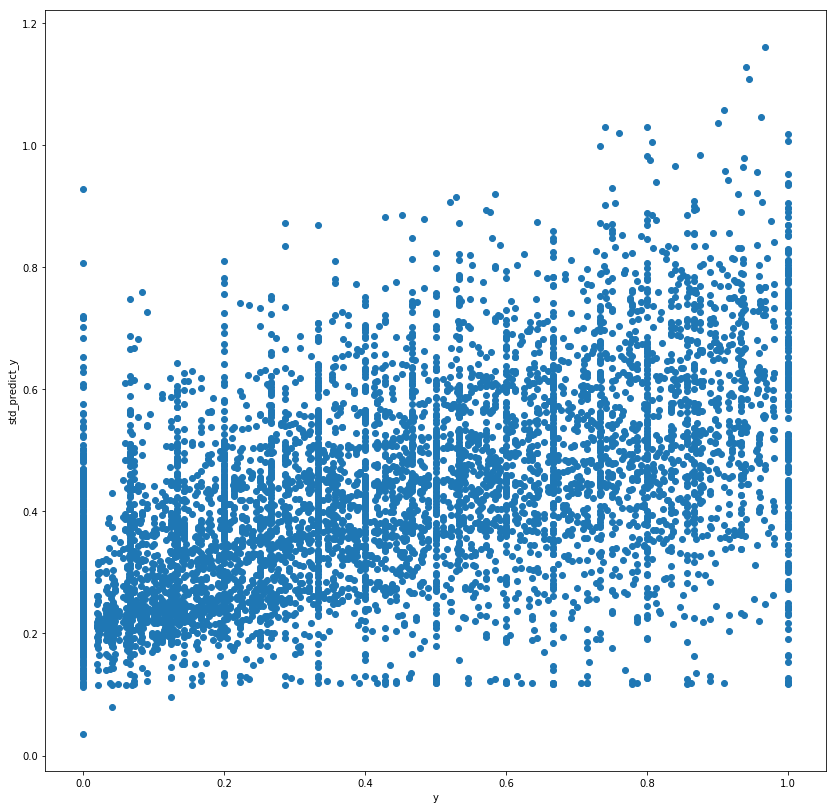

In [77]:
f, ax = plt.subplots(figsize=(14, 14))
plt.scatter(result['winPlacePerc'], result['predict'])
plt.xlabel("y")
plt.ylabel("std_predict_y")
plt.savefig("./graph/final_1/final1_other_MLRegress_exclude_inputs_with_stdnorm.png")
plt.show()

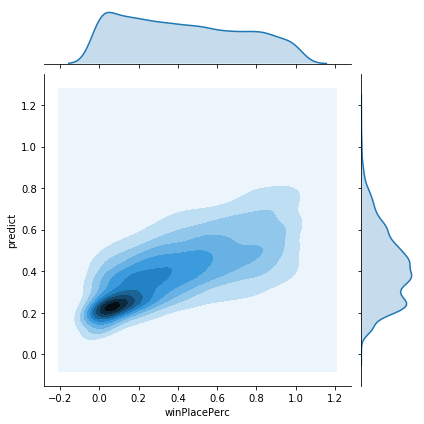

In [78]:
# 회귀분석은 1의값은 예측을 잘하지만, 가운데 값과 0의 값은 예측을 잘하지 못함
sns_plot = sns.jointplot(x= 'winPlacePerc', y= 'predict', data=result, kind='kde')
sns_plot.savefig("./graph/final_1/final1_other_MLRegress_exclude_inputs_with_stdnorm_kde.png")